###Instalar paquetes

In [43]:
!pip install nixtla
!pip install xgboost
!pip install torch
!pip install neuralforecast
!pip install psutil

###Llamar dependencias

In [54]:
from nixtla import NixtlaClient

API_KEY = "nixak-jsNhpCMbb57LXMig3cRT4Kjddj11ncuh1pQvNiMyg2wqRfIQDdQmC9XQ3sPtdsr6mlu1bnTBfAD1aBa3" # Esta es la API key que se obtiene desde el sitio web de nixtla

# Se inicializa el cliente con la API key de TimeGPT
nixtla_client = NixtlaClient(
    api_key=API_KEY
)
# Verifica que la clave funcione
assert nixtla_client.validate_api_key()

###Ejecutar importaciones

In [61]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import psutil
import os

# Modelo mezclado: TimeGPT+XGBoost

##TimeGPT: Modelo pre-entrenado con bases de datos previas

###Carga de datos

In [59]:
# 1) Carga y wide→long
df = pd.read_excel("datav2.xlsx", sheet_name=0)
df_long = pd.wide_to_long(
    df, stubnames=["demanda","precio"],
    i="fecha", j="product_num", sep="", suffix=r"\d+"
).reset_index().rename(columns={
    "fecha":"ds","product_num":"unique_id",
    "demanda":"y","precio":"price"
})
df_long["unique_id"] = "prod_"+df_long["unique_id"].astype(str)
df_long["ds"] = pd.to_datetime(df_long["ds"])
df_long = df_long.sort_values(["unique_id","ds"])

# 2) Split 4 últimas semanas
h = 4 # Mantener las últimas cuatro semanas para hacer el testing de la predicción
train_df = (df_long
    .groupby("unique_id", group_keys=False)
    .apply(lambda g: g.iloc[:-h])
    .reset_index(drop=True)
)
test_df  = (df_long
    .groupby("unique_id", group_keys=False)
    .apply(lambda g: g.iloc[-h:])
    .reset_index(drop=True)
)

print("Dataset test_df:\n", test_df.head(15))
print("\n...\n", test_df.tail(15))
print(f"\nDimensiones del Dataset (filas, columnas): {test_df.shape}\n")

Dataset test_df:
            ds unique_id  idx     y  price
0  2025-02-07    prod_1  215  2218  28.79
1  2025-02-14    prod_1  216  2794  28.79
2  2025-02-21    prod_1  217  1697  28.79
3  2025-02-28    prod_1  218  2937  35.99
4  2025-02-07   prod_10  215  4172  17.59
5  2025-02-14   prod_10  216  4739  17.59
6  2025-02-21   prod_10  217  7251  17.59
7  2025-02-28   prod_10  218  8629  21.99
8  2025-02-07    prod_2  215  7117  20.79
9  2025-02-14    prod_2  216  5224  20.79
10 2025-02-21    prod_2  217  3279  20.79
11 2025-02-28    prod_2  218  4997  25.99
12 2025-02-07    prod_3  215  5637  31.99
13 2025-02-14    prod_3  216  3268  31.99
14 2025-02-21    prod_3  217  3202  31.99

...
            ds unique_id  idx     y  price
25 2025-02-14    prod_6  216  2786  44.80
26 2025-02-21    prod_6  217   788  44.80
27 2025-02-28    prod_6  218  2205  56.00
28 2025-02-07    prod_7  215  3619  71.99
29 2025-02-14    prod_7  216  4583  71.99
30 2025-02-21    prod_7  217  4853  71.99
31 2025-02

<ipython-input-59-3fe95ca03d5b>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[:-h])
<ipython-input-59-3fe95ca03d5b>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[-h:])


In [63]:
# 3) Forecast base con TimeGPT
X_fut = test_df[["unique_id","ds","price"]] # Se le deben entregar los precios del "futuro"

fcst = nixtla_client.forecast(
    df=train_df,       # ← aquí el modelo utiliza la data histórica para la predicción
    X_df=X_fut,        # ← aquí hace el pronóstico de la demanda para esas 4 semanas futuras
    h=4,
    freq="W-FRI",
    target_col="y",
    model="timegpt-1",
    finetune_steps=5,
    finetune_loss="mse",
    finetune_depth=5,
)

fcst["ds"] = pd.to_datetime(fcst["ds"])
fcst = fcst.rename(columns={"TimeGPT":"yhat_base"}) # "yhat" ahora es la columna con el resultado de la predicción

prediccion_timegpt= fcst["yhat_base"]

print("Vector de demanda estiada y_hat:\n",prediccion_timegpt.head())
print(f"\nDimensiones del vector de predicción: {prediccion_timegpt.shape}\n")

# --- Uso de recursos ---
proc = psutil.Process(os.getpid())
mem = proc.memory_info().rss / (1024**2)      # MB
cpu = psutil.cpu_percent(interval=0.5)        # %
print(f"Memoria RSS: {mem:.1f} MB — CPU: {cpu:.1f}%")

/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:397: UserWarning: `df` contains the following exogenous features: ['idx'], but they were not found in `X_df` nor declared in `hist_exog_list`. They will be ignored.
  warnings.warn(


Vector de demanda estiada y_hat:
 0    1819.9513
1    1813.4713
2    1818.7706
3    2303.3975
4    7244.5723
Name: yhat_base, dtype: float64

Dimensiones del vector de predicción: (40,)

Memoria RSS: 1558.8 MB — CPU: 2.0%


In [73]:
# Evaluación
y_real = test_df["y"].to_numpy()
y_gorro = prediccion_timegpt.to_numpy()

mae_base  = mean_absolute_error(y_real, y_gorro)
rmse_base = np.sqrt(mean_squared_error(y_real, y_gorro))
mape_base = np.mean(np.abs((y_real - y_gorro) / y_real)) * 100
bias_base = np.mean(y_gorro - y_real)

print("=== Métricas TimeGPT (base) ===")
print(f"MAE : {mae_base:.2f}")
print(f"RMSE: {rmse_base:.2f}")
print(f"MAPE: {mape_base:.2f}%")
print(f"Bias: {bias_base:.2f}")

print("\nVectores:")
print(f"\t-- y_hat (demanda estimada):\n",'\t',y_gorro,"\n")
print(f"\t-- y_real (demanda real)\n",'\t',y_real,'\n')

=== Métricas TimeGPT (base) ===
MAE : 975.84
RMSE: 1328.21
MAPE: 32.17%
Bias: -27.89

Vectores:
	-- y_hat (demanda estimada):
 	 [1819.9513 1813.4713 1818.7706 2303.3975 7244.5723 7286.8164 7177.2114
 8591.182  4898.5444 4966.494  5048.884  6540.7734 3231.6892 3239.5735
 3350.592  3786.6616 1451.698  1470.5028 1529.458  1666.133  5804.331
 5820.1523 5584.37   7040.07   2621.801  2617.593  2576.5112 2767.9915
 4093.0193 4180.789  4142.1826 4311.26   3108.3264 3010.1233 3061.3394
 3499.3005 3305.7502 3299.3738 3374.5269 3702.282 ] 

	-- y_real (demanda real)
 	 [2218 2794 1697 2937 4172 4739 7251 8629 7117 5224 3279 4997 5637 3268
 3202 3771 1107 2073 1796 2305 6007 8134 8308 4364  901 2786  788 2205
 3619 4583 4853 2886 3481 2298 3144 4791 3922 4944 3340 4706] 



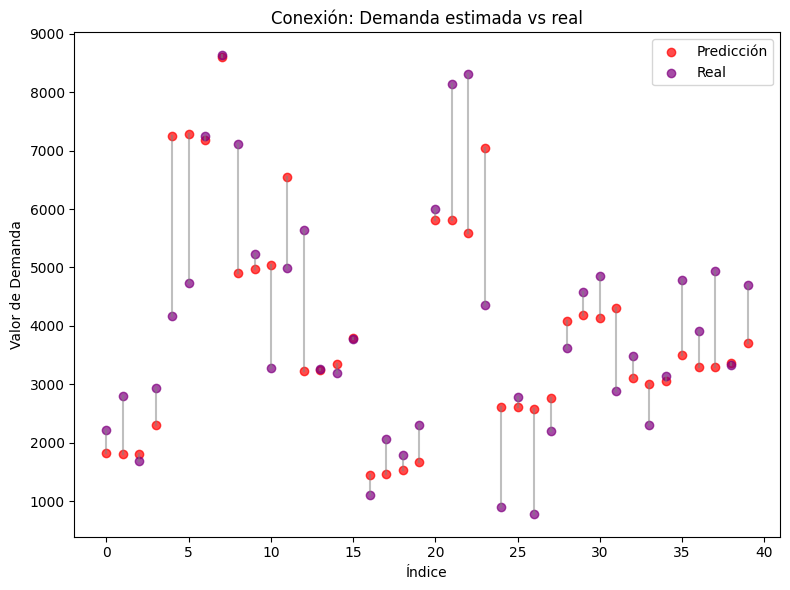

In [74]:
indices = list(range(len(y_gorro)))

plt.figure(figsize=(8, 6))

# Dibujar líneas que conectan cada par de puntos (predicción ↔ real)
for i in indices:
    plt.plot([i, i], [y_gorro[i], y_real[i]], color='gray', alpha=0.5)

# Scatter de predicción (rojo) y real (morado)
plt.scatter(indices, y_gorro, color="red", alpha=0.7, label="Predicción")
plt.scatter(indices, y_real, color="purple", alpha=0.7, label="Real")

plt.xlabel("Índice")
plt.ylabel("Valor de Demanda")
plt.title("Conexión: Demanda estimada vs real")
plt.legend()
plt.tight_layout()
plt.show()

###Para tienda 2:

#Finetuning de modelos de redes neuronales

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
import psutil
import os

##Red neuronal N-hits

###Carga de tados para tienda 1 y tienda 2

In [23]:
# 1) Carga y transformación a formato long
df = pd.read_excel("datav2.xlsx", sheet_name=0) #cambiar a df_t1
df_long = pd.wide_to_long(
    df,
    stubnames=["demanda", "precio"],
    i="fecha",
    j="product_num",
    sep="",
    suffix=r"\d+"
).reset_index().rename(columns={
    "fecha":       "ds",
    "product_num": "unique_id",
    "demanda":     "y",
    "precio":      "price"
})
df_long["unique_id"] = "prod_" + df_long["unique_id"].astype(str)
df_long["ds"]        = pd.to_datetime(df_long["ds"])
df_long               = df_long.sort_values(["unique_id", "ds"]).reset_index(drop=True)

# 2) Split últimas h=4 semanas para test
h = 4
train_df = (
    df_long
    .groupby("unique_id", group_keys=False)
    .apply(lambda g: g.iloc[:-h])
    .reset_index(drop=True)
)
test_df = (
    df_long
    .groupby("unique_id", group_keys=False)
    .apply(lambda g: g.iloc[-h:])
    .reset_index(drop=True)
)

# 2.b) Agregar columna 'yhat_base' que copie la demanda histórica
#train_df["yhat_base"] = train_df["y"]

print(f"Train rows: {len(train_df)}, Test rows: {len(test_df)}")
print("Tabla train_df:\n")
print(train_df.head(), '\n')

Train rows: 2140, Test rows: 40
Tabla train_df:

          ds unique_id  idx     y  price
0 2021-01-01    prod_1    1  1950  28.79
1 2021-01-08    prod_1    2  2063  28.79
2 2021-01-15    prod_1    3  2392  35.99
3 2021-01-22    prod_1    4  3936  35.99
4 2021-01-29    prod_1    5  3616  35.99 



<ipython-input-23-2db73cac1692>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[:-h])
<ipython-input-23-2db73cac1692>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[-h:])


In [40]:
# 3) Instancia y configura NHITS
nhits_model = NHITS(
    h=h,                        # horizonte de pronóstico: número de pasos a predecir en el futuro (aquí 4 semanas)
    input_size=12+6,          # tamaño de la ventana de entrada que toma en cuenta para detectar patrones: 12 puntos de demanda histórica + 6 puntos de precio histórico
    hist_exog_list=["price"],   # lista de vars. exógenas históricas que el modelo ve durante el entrenamiento
    futr_exog_list=["price"],   # lista de exógenas futuras: variables externas (aca solo precio) que el modelo utilizará para cada paso del pronóstico
    max_steps=100,              # número máximo de iteraciones de entrenamiento (epochs) para ajustar la red
    mlp_units=[                 # arquitectura del MLP interno (red neuronal): número de neuronas por capa en cada bloque
        [32, 64],               #   primer bloque: capas de 32 y luego 64 unidades
        [64, 128],              #   segundo bloque: capas de 64 y luego 128 unidades
        [128, 256]              #   tercer bloque: capas de 128 y luego 256 unidades
    ],
    dropout_prob_theta=0.5,     # probabilidad de "dropout" de neuronas: apaga aleotoriamente neuronas durante "epochs" para evitar overfitting
    pooling_mode="AvgPool1d",   # modo de pooling: método para reducir dimensionalidad entre bloques
    step_size=10,               # tamaño del paso para el método del gradiente del optimizador interno
)

# Aquí envolvemos en NeuralForecast para que termine de adoptar forma de red neronal:
model = NeuralForecast(
    models=[nhits_model],
    freq="W-FRI", # se fija el comienzo de las semanas desde los viernes
)

model.fit(df=train_df)  # se procede a realizar el entrenamiento de la red


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 149 K  | train
-------------------------------------------------------
149 K     Trainable params
0         Non-trainable params
149 K     Total params
0.599     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


In [64]:
# El Dataframe futr_df es el  con las tres columnas mínimas:
#    'unique_id', 'ds' y los exógenos futuros ('price')
futr_df = test_df[['unique_id','ds','price']].copy() # NO le debemos entregar la columna objetivo y (demanda real)

# 3) Llamas a predict SOLO con futr_df
fcst = model.predict(futr_df=futr_df)

fcst = fcst.rename(columns={"NHITS":"yhat"})
prediccion_nhits=fcst["yhat"]

print("Estimación de de demanda para 4 semanas:\n", prediccion_nhits.head(10),"\n...\n",prediccion_nhits.tail(10))
print(f"\n Dimensiones del vector estiamdo yhat\n:", prediccion_nhits.shape)

# Imprime recursos sólo después del predict
proc = psutil.Process(os.getpid())
mem = proc.memory_info().rss / (1024**2)       # MB
cpu = psutil.cpu_percent(interval=0.5)         # %
print("\nUso de recursos:\n",f"Memoria RSS: {mem:.1f} MB — CPU: {cpu:.1f}%")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Estimación de de demanda para 4 semanas:
 0    2217.933594
1    2277.712891
2    2205.854492
3    2441.698242
4    8591.827148
5    8656.187500
6    8555.462891
7    8690.043945
8    4638.298828
9    4744.709961
Name: yhat, dtype: float32 
...
 30    4792.768066
31    4513.232910
32    3418.936523
33    3524.219238
34    3529.357910
35    3478.902344
36    3685.637207
37    4088.508057
38    4030.458984
39    3796.729736
Name: yhat, dtype: float32

 Dimensiones del vector estiamdo yhat
: (40,)

Uso de recursos:
 Memoria RSS: 1559.0 MB — CPU: 8.1%


In [65]:
# --------------- 4) comparación con demanda real -------------

y_real = test_df["y"].to_numpy() # tambien tiene dimension (40,0) o sea un vector de 40 entradas
y_pred = prediccion_nhits

mae   = mean_absolute_error(y_real, y_pred)
rmse  = np.sqrt(mean_squared_error(y_real, y_pred))
mape  = np.mean(np.abs((y_real - y_pred)/y_real))*100
bias  = np.mean(y_pred - y_real)

print("=== Métricas NHITS con yhat_base como exógena futura ===")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Bias: {bias:.2f}")


=== Métricas NHITS con yhat_base como exógena futura ===
MAE : 1017.07
RMSE: 1475.69
MAPE: 33.50%
Bias: 281.46


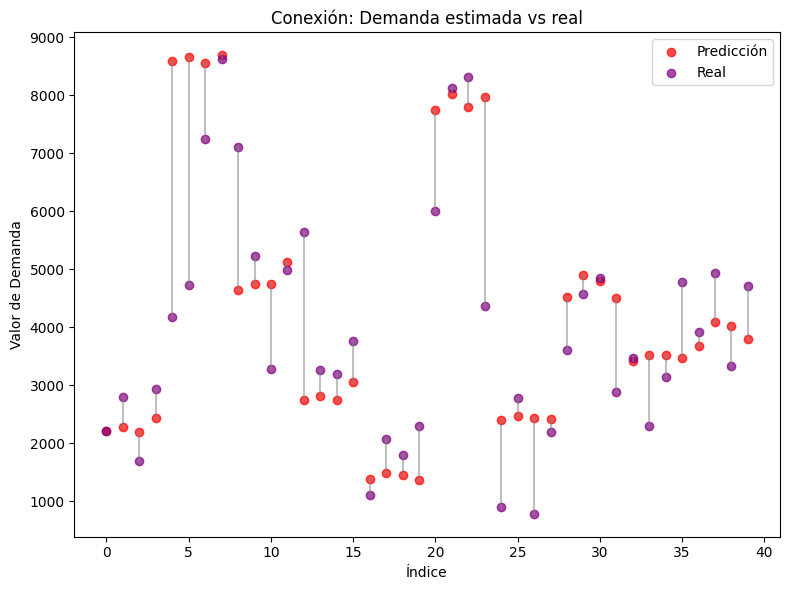

In [53]:
indices = list(range(len(y_pred)))

plt.figure(figsize=(8, 6))

# Dibujar líneas que conectan cada par de puntos (predicción ↔ real)
for i in indices:
    plt.plot([i, i], [y_pred[i], y_real[i]], color='gray', alpha=0.5)

# Scatter de predicción (rojo) y real (morado)
plt.scatter(indices, y_pred, color="red", alpha=0.7, label="Predicción")
plt.scatter(indices, y_real, color="purple", alpha=0.7, label="Real")

plt.xlabel("Índice")
plt.ylabel("Valor de Demanda")
plt.title("Conexión: Demanda estimada vs real")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
#  ─── CONGELA TODO menos el último BLOQUE de NHITS ─────────────────
base = model.models[0]

# 1) freeze all
for p in base.parameters():
    p.requires_grad = False

# 2) unfreeze TODO el último bloque (blocks[-1])
#    así tendrás parámetros que entrenar y el backward funcionará
for p in base.blocks[-2:].parameters():
    p.requires_grad = True

# 4) Entrena únicamente esa capa final
model.fit(df=train_df)

# 5) Predice las próximas h semanas (pasando exógenas)
futr_df = test_df[["unique_id","ds","price"]]
fcst    = model.predict(df=train_df, futr_df=futr_df)

# renombra
fcst = fcst.rename(columns={"NHITS":"yhat"}).assign(ds=lambda d: pd.to_datetime(d.ds))

# 6) Merge + métricas
eval_df = test_df.merge(
    fcst[["unique_id","ds","yhat"]],
    on=["unique_id","ds"]
)

y_true = eval_df["y"].values
y_pred = eval_df["yhat"].values

mae   = mean_absolute_error(y_true, y_pred)
rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
mape  = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
bias  = np.mean(y_pred - y_true)

print("=== Métricas 4-semanas con última capa tuneada ===")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Bias: {bias:.2f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 149 K  | train
-------------------------------------------------------
100 K     Trainable params
49.3 K    Non-trainable params
149 K     Total params
0.599     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

=== Métricas 4-semanas con última capa tuneada ===
MAE : 1031.09
RMSE: 1388.99
MAPE: 34.15%
Bias: 132.78


Los resultados empeoraron por lo que se decidió no seguir aplicando cambios directos a estructura interna.